In [1]:
# Cloud Mask 2.0 

import ee
import yaml
import time
import os
import json
from argparse import ArgumentParser
from utils import clipToROI, exportImageCollectionToGCS, exportImageToGCS, sentinel2CloudScore, calcCloudCoverage
from utils import GEETaskManager

from gevent.fileobject import FileObjectThread

# Polygon Import from Misha ROI List

import pandas as pd

# Functions for Active Run of Cloud Mask 2.0 

from download_sen12 import *

C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [ ]:
config_file = "config.yml"

In [ ]:
stream = open(config_file, 'r') 

In [ ]:
config = yaml.load(stream)

In [ ]:
config["data_list"][0]

In [ ]:
config

# Initialize EE

In [ ]:
ee.Initialize()

# Creating New Feature Collection To Use with CM_v2

In [ ]:
def import_aois(csv_loc):    

    df_labels = pd.read_csv(csv_loc)
    df_labels = df_labels[["center-lat","center-long","polygon","Labels combined"]]

    polygons = []
    for polygon in df_labels["polygon"]:
        polygons.append(json.loads(polygon)["coordinates"])

    return polygons

polygons = import_aois("D:/canopy_data/csvs/polygons_101320.csv")

feature_id = 0 
features = []
for poly in polygons[0:3]:
    # create an roi. first item in Misha's label list
    feature_id += 1 
    
    # create geometry object, create feature object, append to features list for feature collection creation 
    polys = ee.Geometry.Polygon(poly)
    feature = ee.Feature(polys,{"name":feature_id})
    features.append(feature)

fc = ee.FeatureCollection(features)

In [ ]:
fc

In [ ]:
task_queue = GEETaskManager(n_workers=config['max_tasks'], max_retry=config['max_retry'], wake_on_task=True, log_file=config['log_file'], process_timeout=config['task_timeout'])
task_queue.register_monitor(monitor_tasks)

if os.path.exists('task_log.json'):
    task_log = load_task_log(filename='task_log.json')
    task_queue.set_task_log(task_log)

for data_list in config['data_list'][0:1]:
    for sensor_idx in data_list['sensors']:
        sensor = config['sensors'][sensor_idx]
        print(sensor)
        tasks = process_datasource(task_queue, data_list, sensor, config['export_to'], config['export_dest'], feature_list = fc)

print("Waiting for completion...")
task_queue.wait_till_done()

In [ ]:
d = {'a': 1, 'b': 2, 'c': 3}

d.keys()

In [ ]:
list(d.keys())[0]

In [ ]:
list(d.values())[0]

In [ ]:
d.items()

In [ ]:
e = {'d': d, 'e': 0}

e

In [ ]:
list(list(e.values())[0].keys())[0]

In [ ]:
task_queue = GEETaskManager(n_workers=config['max_tasks'], max_retry=config['max_retry'], wake_on_task=True, log_file=config['log_file'], process_timeout=config['task_timeout'])
task_queue.register_monitor(monitor_tasks)

if os.path.exists('task_log.json'):
    task_log = load_task_log(filename='task_log.json')
    task_queue.set_task_log(task_log)

for data_list in config['data_list']:
    for sensor_idx in data_list['sensors']:
        sensor = config['sensors'][sensor_idx]
        tasks = process_datasource(task_queue, data_list, sensor, config['export_to'], config['export_dest'])

print("Waiting for completion...")
task_queue.wait_till_done()

In [ ]:
!pwd

## makeFilterList

In [ ]:
def makeFilterList(sensor):
    filters_before = None
    filters_after = None

    def _build_filters(filter_list):
        filters = []
        for f in filter_list:
            key = list(f.keys())[0]
            op = list(list(f.values())[0].keys())[0]
            val = list(list(f.values())[0].values())[0]
            filters.append(getattr(ee.Filter, op)(key, val))

        return filters

    if 'filters_before' in sensor:
        filters_before = _build_filters(sensor['filters_before'])

    if 'filters_after' in sensor:
        filters_after = _build_filters(sensor['filters_after'])

    return filters_before, filters_after

In [ ]:
type(config)

In [ ]:
config.keys()

In [ ]:
config

In [ ]:
config['sensors']

In [ ]:
sensor = config['sensors'][0]
sensor

In [ ]:
# Default values
filters_before = None
filters_after = None

In [ ]:
# Sub function
def _build_filters(filter_list):
    # filter_list is a list of dictionaries. Includes the attributes for filtering an image collection
    filters = []
    # for each dict in filter_list
    # example: {'CLOUDY_PERCENTAGE': {'lte': 10}}
    for f in filter_list:
        # key is the first key of the dict -- the feature you're trying to filter by
        # example: 'CLOUDY_PERCENTAGE'
        key = list(f.keys())[0]
        # op is the key of the nested dictionary
        # example: 'lte'
        op = list(list(f.values())[0].keys())[0]
        # val is the value of the nested dictionary
        # example: 10
        val = list(list(f.values())[0].values())[0]
        # Make an ee.Filter object that matches the input filter dict
        # example: ee.Filter.lte('CLOUDY_PERCENTAGE', 10)
        # This will then get applied to an image_collection object
        filters.append(getattr(ee.Filter, op)(key, val))

In [ ]:
help(ee.Filter)

In [ ]:
# Because of the sorting (probably), you may want to apply filters specifically
# before or after creating the image_collection object.
# So we have separate filter lists for both before and after.
if 'filters_before' in sensor:
    filters_before = _build_filters(sensor['filters_before'])

if 'filters_after' in sensor:
    filters_after = _build_filters(sensor['filters_after'])
    
# So at the end, we build a list of ee.Filter objects based off of the sensor
# values for its 'filters_before' and 'filters_after' keys. If the sensor
# lacks one or both such keys, the filters_before and filters_after retain
# their default None value (i.e. no filters get applied).

In [ ]:
ee.Initialize()

In [ ]:
makeFilterList(sensor)

## makeImageCollection

In [ ]:
def makeImageCollection(sensor, roi, start_date, end_date, modifiers=[]):
    # Make the filters based off of the previous function
    filters_before, filters_after = makeFilterList(sensor)

    # Make an image collection. Take the name from the sensor.
    # Filter by date based off of start_date and end_date.
    # Filter bounds based off of the ROI.
    # The map method applies an additional function as a filter; in this case,
    # a clipToROI function that crops every image result in the collection.
    # This way you only have the piece of the image that you're concerned with.
    collection = ee.ImageCollection(sensor['name']) \
                .filterDate(ee.Date(start_date), ee.Date(end_date)) \
                .filterBounds(roi) \
                ### NOTE: Does this need the lambda??
                .map( lambda x: clipToROI(x, ee.Geometry(roi)) )

    # If there are filters_before, apply them
    if filters_before is not None:
        collection = collection.filter( filters_before )

    # If there are additional functions you want to apply, put them in the
    # "modifiers" list and then they will be applied in turn using the 'map' method
    if modifiers and len(modifiers) > 0:
        for m in modifiers:
            collection = collection.map(m)

    # If there are filters_after, apply them
    if filters_after:
        collection = collection.filter( filters_after )

    # 'sensor' states the specific bands you want to take in the 'bands' value.
    # Return those bands of the image collection.
    # This is done at the end just in case other bands are used in custom (pre-)processing--
    # i.e., in the "modifiers" list
    return collection.select(sensor['bands'])

## process_datasource

In [ ]:
def process_datasource(task_queue, source, sensor, export_to, export_dest, feature_list = None):
    # feature_list = ee.FeatureCollection(source['features_src'])
    feature_list = feature_list.sort(source['sort_by']).toList(feature_list.size())
    n_features = feature_list.size().getInfo()

    print("{} features have been loaded".format(n_features))

    task_list = []

    for i in range(1, n_features):
        feature_point = ee.Feature( feature_list.get(i) )

        if source['geometry'] == "point":
            feature_point = feature_point.buffer(source['size']).bounds()

        roi = feature_point.geometry()
        roi = roi.coordinates().getInfo()

        if isinstance(source['name'], str):
            source['name'] = [source['name']]

        if isinstance(sensor['prefix'], str):
            sensor['prefix'] = [sensor['prefix']]

        if 'prefix' in sensor:
            filename_parts = sensor['prefix'] + source['name']
        else:
            filename_parts = source['name']

        filename = "_".join(source['name'] + [str(i)])
        dest_path = "/".join(filename_parts + [filename])

        export_params = {
            'bucket': export_dest,
            'resolution': source['resolution'],
            'filename': filename,
            'dest_path': dest_path
        }

        task_params = {
            'action': export_single_feature,
            'id': "_".join(filename_parts + [str(i)]), # This must be unique per task, to allow to track retries
            'kwargs': {
                'roi': roi,
                'export_params': export_params,
                'sensor': sensor,
                'date_range': {'start_date': source['start_date'], 'end_date': source['end_date']}
            }
        }

        task_queue.add_task(task_params, blocking=True)

In [ ]:
def process_datasource(task_queue, source, sensor, export_to, export_dest, feature_list = None)
### NOTE: We're going to remove the task_queue probably

In [ ]:
# the feature_list is an ee.FeatureCollection
# This sorts the feature_list by the parameter in source['sort_by']
feature_list = feature_list.sort(source['sort_by']).toList(feature_list.size())
# get the number of features in the feature_list
n_features = feature_list.size().getInfo()

In [ ]:
fc

In [ ]:
fc.toList(fc.size())

In [ ]:
help(fc.toList)

In [ ]:
fc.size().getInfo()

In [ ]:
type(fc.size())

In [ ]:
help(ee.ee_number.Number)

In [ ]:
task_list = []
# This variable is not used so I don't know why it's defined

In [ ]:
for i in range(1, n_features):
    feature_point = ee.Feature( feature_list.get(i) )

In [ ]:
feature_list = fc.toList(fc.size())

In [ ]:
type(feature_list)

In [ ]:
help(feature_list.get)

In [ ]:
feature_list.get(0).getInfo()

In [ ]:
feature_list.get(1).getInfo()

In [ ]:
## CHANGE:

for i in range(0, n_features):
    # Loop through each feature. Pull out the feature--
    # need to put it inside an "ee.Feature" because otherwise
    # it's a "ComputedObject."
    feature_point = ee.Feature( feature_list.get(i) )

In [ ]:
feature_point = ee.Feature( feature_list.get(0) )

In [ ]:
type(feature_list.get(0))

In [ ]:
if source['geometry'] == "point":
    # If the feature is a point, then create a bounding box based off
    # of the "size" attribute from 'source', using the defined
    # feature as the centroid.
    feature_point = feature_point.buffer(source['size']).bounds()

In [ ]:
help(feature_point.buffer)

In [ ]:
help(feature_point.bounds)

In [ ]:
# Get the coordinates of feature_point as the ROI
roi = feature_point.geometry()
roi = roi.coordinates().getInfo()

In [ ]:
## if type(source['name']) == str
if isinstance(source['name'], str):
    # make it into a list, so we don't error out
    source['name'] = [source['name']]
    
# same as above
if isinstance(sensor['prefix'], str):
    sensor['prefix'] = [sensor['prefix']]

In [ ]:
# make a list 'filename_parts', with all the prefixes
# first (if there are prefixes), then all of the names.
# Keep in mind that at this point, we're working on a single source
# and a single sensor, so really there's just one prefix and one name;
# however, these each might be divided into parts and put into a list
# so that we can then join all the parts together later.
if 'prefix' in sensor:
    filename_parts = sensor['prefix'] + source['name']
else:
    filename_parts = source['name']

In [ ]:
# Filename is the source name, underscore, then an integer
# (integer depends on which feature we're wroking on)
filename = "_".join(source['name'] + [str(i)])
# dest_path is the filename parts joined by backlashses, then the filename
dest_path = "/".join(filename_parts + [filename])

In [ ]:
# Define export parameters
export_params = {
    # export bucket is one of the arguments to the overall function
    'bucket': export_dest,
    # resolution comes from the source
    'resolution': source['resolution'],
    # filename and dest_path defined above
    'filename': filename,
    'dest_path': dest_path
}

In [ ]:
# Define task parameters for the async stuff
task_params = {
    # Function to run: export_single_feature
    'action': export_single_feature,
    # ID for the async stuff to track each task
    'id': "_".join(filename_parts + [str(i)]), # This must be unique per task, to allow to track retries
    'kwargs': {
        # kwargs come from the variables defined in-function
        'roi': roi,
        'export_params': export_params,
        'sensor': sensor,
        'date_range': {'start_date': source['start_date'], 'end_date': source['end_date']}
    }
}

In [ ]:
# async line
task_queue.add_task(task_params, blocking=True)

In [ ]:
l1 = [1, 2, 3]
l2 = [4, 5, 6]
l1 + l2

In [ ]:
config['sensors']

In [ ]:
sensor = config['sensors'][0]

In [ ]:
config.keys()

In [ ]:
config['data_list']

In [ ]:
source = config['data_list'][0]

In [ ]:
source['name']

## export_single_feature

In [ ]:
def export_single_feature(roi=None, sensor=None, date_range=None, export_params=None):
    modifiers = None
    if sensor['type'].lower() == "opt":
        #print(sensor['type'])
        modifiers = [sentinel2CloudScore, calcCloudCoverage]

    roi_ee = ee.Geometry.Polygon(roi[0])
    image_collection = makeImageCollection(sensor, roi_ee, date_range['start_date'], date_range['end_date'], modifiers=modifiers)
    img = ee.Image(image_collection.mosaic())

    new_params = export_params.copy()
    new_params['img'] = img
    new_params['roi'] = roi

    return exportImageToGCS(**new_params)

In [ ]:
# roi, sensor, date_range, export_params
export_single_feature(roi=None, sensor=None, date_range=None, export_params=None)

In [ ]:
# default modifiers value
modifiers = None
# if the sensor type is "opt" (optical)
if sensor['type'].lower() == "opt":
    #print(sensor['type'])
    # then the modifiers is the following two functions from utils.
    # the only reason to run these functions is if you're getting
    # optical products (i.e. rasters)
    modifiers = [sentinel2CloudScore, calcCloudCoverage]

In [ ]:
# Getting the RoI as an EE Geometry (Polygon) object
roi_ee = ee.Geometry.Polygon(roi[0])

# run the makeImageCollection function that is pulled from utils
image_collection = makeImageCollection(sensor, roi_ee, date_range['start_date'], date_range['end_date'], modifiers=modifiers)

# get a single image by mosaicing the image collection.
# this will naturally do a pixel replacement (i.e. we're flattening the products)
img = ee.Image(image_collection.mosaic())

In [ ]:
# copy the export_params, then add 'img' and 'roi' key/value pairs
new_params = export_params.copy()
new_params['img'] = img
new_params['roi'] = roi

In [ ]:
# run exportImageToGCS (pulled from utils) on the new_params
return exportImageToGCS(**new_params)

# TESTING (ZHENYA START HERE)

In [1]:
import ee
import yaml
import time
import os
import json
import pandas as pd
from utils import exportImageToGDrive,exportImageToGCS
from download_sen12 import *

ee.Initialize()

C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [ ]:
# def process_datasource(source, sensor, export_folder, feature_collection = None):
#     # feature_list = ee.FeatureCollection(source['features_src'])
#     feature_list = feature_collection.sort(source['sort_by']).toList(feature_collection.size())
#     n_features = feature_list.size().getInfo()

#     print("{} features have been loaded".format(n_features))

#     for i in range(0, n_features):
#         feature_point = ee.Feature( feature_list.get(i) )

# #         if source['geometry'] == "point":
# #             feature_point = feature_point.buffer(source['size']).bounds()

#         roi = feature_point.geometry()
#         roi = roi.coordinates().getInfo()

#         if isinstance(source['name'], str):
#             source['name'] = [source['name']]

#         if isinstance(sensor['prefix'], str):
#             sensor['prefix'] = [sensor['prefix']]

#         if 'prefix' in sensor:
#             filename_parts = sensor['prefix'] + source['name']
#         else:
#             filename_parts = source['name']
            
#         time_stamp = "_".join(time.ctime().split(" ")[1:])

#         filename = "_".join(source['name'] + [str(i)])
        
#         dest_path = "/".join(filename_parts + [filename])
#         print(dest_path)

#         export_params = {
# #             'drive_folder': export_folder,
#             'bucket' : export_folder,
#             'resolution': source['resolution'],
#             'filename': filename,
#             'dest_path': dest_path
#         }
        
        
        
# #         return export_single_feature(roi=roi, export_params=export_params,
# #                                      sensor=sensor,
# #                                      date_range={'start_date': source['start_date'],
# #                                                  'end_date': source['end_date']})
    
    
# def export_single_feature(roi=None, sensor=None, date_range=None, export_params=None):
#     modifiers = None
#     if sensor['type'].lower() == "opt":
#         #print(sensor['type'])
#         modifiers = [sentinel2CloudScore, calcCloudCoverage]

#     roi_ee = ee.Geometry.Polygon(roi[0])
#     image_collection = makeImageCollection(sensor, roi_ee, date_range['start_date'], date_range['end_date'], modifiers=modifiers)
#     img = image_collection.mosaic().clip(roi_ee)
#     print(img.getInfo())
    

#     new_params = export_params.copy()
#     print(new_params)
#     new_params['img'] = img
#     new_params['roi'] = roi
    
    
#     return exportImageToGCS(**new_params)


# #     return exportImageToGDrive(**new_params)

# def load_config(config_file):
#     stream = open(config_file, 'r') 
#     return yaml.load(stream)

In [2]:
config_dict = load_config('config.yml')
source = config_dict['data_list'][0]
sensor = config_dict['sensors'][0]
# export_folder = config_dict['drive_folder']
export_folder = config_dict['bucket']

print(export_folder)

project-canopy-temp-2


C:\Users\David\canopy\canopy-gis\google-earth-explore\GEE_DataDownloader\download_sen12.py:199: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(stream)


In [3]:
print(source['name'])

['full_polygon_test']


In [3]:
def import_aois(csv_loc):    

    df_labels = pd.read_csv(csv_loc)
    df_labels = df_labels[["center-lat","center-long","polygon","Labels combined"]]

    polygons = []
    for polygon in df_labels["polygon"]:
        polygons.append(json.loads(polygon)["coordinates"])

    return polygons

### CHANGE BELOW PATH ###
zhenya_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Tiles_v3/Polygon_List/polygons_101320.csv"
david_path = 'D:/canopy_data/csvs/polygons_101320.csv'
polygons = import_aois(david_path)

feature_id = 0 
features = []
for poly in polygons[0:2]:
    # create an roi. first item in Misha's label list
    feature_id += 1 
    
    # create geometry object, create feature object, append to features list for feature collection creation 
    polys = ee.Geometry.Polygon(poly)
    feature = ee.Feature(polys,{"name":feature_id})
    features.append(feature)

fc = ee.FeatureCollection(features)

In [4]:
export = process_datasource(source, sensor, export_folder, fc)

2 features have been loaded
processing  1_pipeline_v2_test_1_Nov_16_10:19:39_2020
Inject B10
processing  2_pipeline_v2_test_1_Nov_16_10:19:40_2020
Inject B10


C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [6]:
while export.active():
    print(export.status(), end="\r", flush=True)

In [5]:
feature_id = 0 
features = []
for poly in polygons:
    # create an roi. first item in Misha's label list
    feature_id += 1 
    
    # create geometry object, create feature object, append to features list for feature collection creation 
    polys = ee.Geometry.Polygon(poly)
    feature = ee.Feature(polys,{"name":feature_id})
    features.append(feature)

fc = ee.FeatureCollection(features)

In [5]:
exports = process_datasource(source, sensor, export_folder, fc)

11 features have been loaded
Inject B10
cloudFree info: {'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [11133, 11133], 'origin': [189243, -44528], 'crs': 'EPSG:4326', 'crs_transform': [8.983152841195215e-05, 0, 0, 0, -8.983152841195215e-05, 0]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [11133, 11133], 'origin': [189243, -44528], 'crs': 'EPSG:4326', 'crs_transform': [8.983152841195215e-05, 0, 0, 0, -8.983152841195215e-05, 0]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [11133, 11133], 'origin': [189243, -44528], 'crs': 'EPSG:4326', 'crs_transform': [8.983152841195215e-05, 0, 0, 0, -8.983152841195215e-05, 0]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [11133, 11133], 'origin': [189243, -44528], 'crs': 'EPSG:43

C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [ ]:
# export = exports[0]

while export.active():
    print(export.status(), end="\r", flush=True)
    
    
    
# any(ele > 10 for ele in test_list)

In [5]:
poly = [[[30.32856063686571, -4.51573131900004],
    [30.328490427200748, -4.51564166671676],
    [29.70310442263468, -4.518245841767282],
    [29.70404948162891, -4.7663448039806235],
    [29.705045180848593, -5.014351831950823],
    [29.706092049542992, -5.262356740121772],
    [29.707190263341428, -5.510359449484687],
    [29.707260531054807, -5.51044914761842],
    [30.111273859321543, -5.508473865846536],
    [30.111479723508978, -5.508055796381344],
    [30.111749302888413, -5.507231139733591],
    [30.171998132726525, -5.234298540870946],
    [30.222206337859667, -5.004799119483313],
    [30.27242829223978, -4.775317149466607],
    [30.290404744521613, -4.69286022598621],
    [30.328475470249696, -4.517102486780663],
    [30.328563980182146, -4.516460193765125],
    [30.32856063686571, -4.51573131900004]]]

polys = ee.Geometry.Polygon(poly)
feature = ee.Feature(polys, {'name': 0})

fc = ee.FeatureCollection([feature])

In [6]:
print(source['name'])

['pipeline_v2_test_1']


In [7]:
source['name'] = ['full_tile_test_v2']

exports = process_datasource(source, sensor, export_folder, fc)

1 features have been loaded
processing  1_full_tile_test_v2_Nov_16_10:56:54_2020
Inject B10


C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


### Planning

Flow of our pipeline--

1. Process Datasource: Sort the feature list and go through each feature one at a time.

2. Export Single Feature: put inputs in the right format for makeImageCollection

3. Make Image Collection: Queries images, applies filters and the map functions

4. Export Single Feature (again): Merges collection, then exports it

To generalize:

1. Split feature list

2. For each feature, make the appropriate image collection

3. Mosaic

4. Export

Proposal is to make a separate image collection for each Tile ID.

1. Put a "tile list" in the config file, as well as a single polygon.

2. Go through each tile in the tile list one at a time.

3. Make an image collection containing only products with that tile.

4. Mosaic that image collection.

5. If any parts of the mosaic lie outside the polygon, clip it. (<-- this part needs testing to see precisely what to do)

6. Export the mosaic tile. (Then repeat for each tile)

In [22]:
def process_datasource_tiles(source, sensor, export_folder, tile_list, main_polygon=None, pre_mosaic_sort='CLOUDY_PERCENTAGE'):

    n_tiles = len(tile_list)

    print(f'{n_tiles} tiles have been loaded')

    exports = []
    
    start_date = source['start_date']
    end_date = source['end_date']
    
    main_collection = ee.ImageCollection(sensor['name']) \
                        .filterDate(ee.Date(start_date), ee.Date(end_date))
    
    if main_polygon:
        main_polygon = ee.Geometry.Polygon(main_polygon)
        main_collection = main_collection.filterBounds(main_polygon_ee)

    if isinstance(source['name'], str):
        source['name'] = [source['name']]

    if 'prefix' in sensor:
        if isinstance(sensor['prefix'], str):
            sensor['prefix'] = [sensor['prefix']]
        filename_parts = sensor['prefix'] + source['name']
    else:
        filename_parts = source['name']

    for i, tile in enumerate(tile_list):
        print(f'Processing tile {tile}')
        
        time_stamp = "_".join(time.ctime().split(" ")[1:])
        filename = "_".join([str(i + 1)] + source['name'] + [time_stamp])
        print("processing ",filename)
        dest_path = "/".join(filename_parts + [filename])

        export_params = {
            'bucket': export_folder,
            'resolution': source['resolution'],
            'filename': filename,
            'dest_path': dest_path
        }

        export = export_single_tile(
            tile=tile,
            main_collection=main_collection,
            main_polygon=main_polygon,
            sensor=sensor,
            export_params=export_params,
            sort_by=pre_mosaic_sort
        )

        exports.append(export)

    return exports

In [48]:
def export_single_tile(tile, main_collection, main_polygon=None, sensor=None, export_params=None, sort_by='CLOUDY_PERCENTAGE'):
    modifiers = []
    if sensor['name'].lower() == "copernicus/s2_sr":
        print('Inject B10')
        modifiers.append(inject_B10)
    if sensor['type'].lower() == "opt":
        #print(sensor['type'])
        modifiers += [sentinel2CloudScore, calcCloudCoverage, sentinel2ProjectShadows, computeQualityScore]

    print('Making tile collection')
    tile_collection = makeTileCollection(sensor, tile, main_collection, modifiers=modifiers)
    return tile_collection
    tile_collection = tile_collection.sort(sort_by)

    print('Making mosaic')
    cloudFree = mergeCollection(tile_collection)
    if main_polygon:
        print('Clipping to polygon')
        cloudFree = cloudFree.clip(main_polygon)
    cloudFree = cloudFree.reproject('EPSG:4326', None, 10)

    new_params = export_params.copy()
    new_params['img'] = cloudFree
    new_params['roi'] = main_polygon
    new_params['sensor_name'] = sensor['name'].lower()
    
    return cloudFree
    
    #return exportImageToGCS(**new_params)

In [33]:
def makeTileCollection(sensor, tile, main_collection, modifiers=[]):
    filters_before, filters_after = makeFilterList(sensor)

    collection = main_collection.filterMetadata('system:index', 'contains', tile)
                
    if filters_before is not None:
        collection = collection.filter( filters_before )

    if modifiers and len(modifiers) > 0:
        for m in modifiers:
            collection = collection.map(m)

    if filters_after:
        collection = collection.filter( filters_after )

    return collection

In [42]:
def exportImageToGCS(img=None, roi=None, bucket=None, filename=None, dest_path=None, resolution=10, start=True, sensor_name=None):
    ## same as in the JS version

    print('Exporting image')
    
    if sensor_name == 'copernicus/s2':
        img = img.select(['B4', 'B3', 'B2'])
    elif sensor_name == 'copernicus/s2_sr':
        img = img.select(['TCI_R', 'TCI_G', 'TCI_B'])

    if roi:
        print('Using ROI')
        export = ee.batch.Export.image.toCloudStorage(
          image=img,
          description=filename,
          scale=resolution,
          region=roi,
          fileNamePrefix=dest_path,
          bucket=bucket,
          maxPixels=1e13
        )
    else:
        print('Not using ROI')
        export = ee.batch.Export.image.toCloudStorage(
            image=img,
            description=filename,
            scale=resolution,
            fileNamePrefix=dest_path,
            bucket=bucket,
            maxPixels=1e13
        )
    
#     print()

    if start:
        export.start()

    return(export)

In [46]:
def mergeCollection(imgC, keepThresh=5, filterBy='CLOUDY_PERCENTAGE', filterType='less_than', mosaicBy='cloudShadowScore'):
    # Select the best images, which are below the cloud free threshold, sort them in reverse order (worst on top) for mosaicing
    ## same as the JS version
    best = imgC.filterMetadata(filterBy, filterType, keepThresh).sort(filterBy, False)
    print('Size of best:', best.size().getInfo())
    #print('Info on first image of collection:', imgC.first().getInfo())
    filtered = imgC.qualityMosaic(mosaicBy)
    print('Type of filtered:', type(filtered))

    # Add the quality mosaic to fill in any missing areas of the ROI which aren't covered by good images
    newC = ee.ImageCollection.fromImages( [filtered, best.mosaic()] )
    
    print('Size of newC:', newC.size().getInfo())

    #return ee.Image(newC.mosaic())

In [36]:
tile_list = ["T32NMK","T32NML","T32NMM"]

In [37]:
config_dict = load_config('config.yml')
source = config_dict['data_list'][0]
sensor = config_dict['sensors'][0]
# export_folder = config_dict['drive_folder']
export_folder = config_dict['bucket']

print(export_folder)

project-canopy-temp-2


C:\Users\David\canopy\canopy-gis\google-earth-explore\GEE_DataDownloader\download_sen12.py:199: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(stream)


In [38]:
print(source)

{'name': ['pipeline_v2_test_1'], 'start_date': '2019-01-01', 'end_date': '2020-12-31', 'geometry': 'point', 'size': 20000, 'resolution': 10, 'sort_by': 'name', 'features_src': 'ft:19Vexm10pJcAZ8tTVbl4j0HA8w2muyPPz6-cyvdxI', 'sensors': [0, 1, 2]}


In [39]:
print(sensor)

{'name': 'COPERNICUS/S2_SR', 'prefix': 'S2_CloudFree', 'type': 'opt', 'bands': ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'TCI_R', 'TCI_G', 'TCI_B'], 'filters_after': [{'CLOUDY_PERCENTAGE': {'lte': 10}}]}


In [43]:
process_datasource_tiles(source, sensor, export_folder, tile_list)

3 tiles have been loaded
Processing tile T32NMK
processing  1_pipeline_v2_test_1_Nov_13_14:01:47_2020
Inject B10
Making tile collection
Making mosaic
Exporting image
Not using ROI
Processing tile T32NML
processing  2_pipeline_v2_test_1_Nov_13_14:01:49_2020
Inject B10
Making tile collection
Making mosaic
Exporting image
Not using ROI
Processing tile T32NMM
processing  3_pipeline_v2_test_1_Nov_13_14:01:49_2020
Inject B10
Making tile collection
Making mosaic
Exporting image
Not using ROI


[<Task EXPORT_IMAGE: 1_pipeline_v2_test_1_Nov_13_14:01:47_2020 (UNSUBMITTED)>,
 <Task EXPORT_IMAGE: 2_pipeline_v2_test_1_Nov_13_14:01:49_2020 (UNSUBMITTED)>,
 <Task EXPORT_IMAGE: 3_pipeline_v2_test_1_Nov_13_14:01:49_2020 (UNSUBMITTED)>]

C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [49]:
collections = process_datasource_tiles(source, sensor, export_folder, tile_list)

3 tiles have been loaded
Processing tile T32NMK
processing  1_pipeline_v2_test_1_Nov_13_14:13:43_2020
Inject B10
Making tile collection
Processing tile T32NML
processing  2_pipeline_v2_test_1_Nov_13_14:13:43_2020
Inject B10
Making tile collection
Processing tile T32NMM
processing  3_pipeline_v2_test_1_Nov_13_14:13:43_2020
Inject B10
Making tile collection


C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [50]:
coll = collections[0]

In [51]:
coll.size().getInfo()

EEException: Collection.reduceColumns: Error in map(ID=20190105T094401_20190105T095815_T32NMK):
Image.clip: The area for image clipping must be a geometry, a Feature or a FeatureCollection.

In [52]:
tile = tile_list[0]

tile

'T32NMK'

In [55]:
start_date = source['start_date']
end_date = source['end_date']
    
main_collection = ee.ImageCollection(sensor['name']) \
                  .filterDate(ee.Date(start_date), ee.Date(end_date))

coll = main_collection.filterMetadata('system:index', 'contains', tile)

C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [56]:
coll.getInfo()

Traceback (most recent call last):
  File "C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\_ffi\loop.py", line 269, in python_check_callback
    def python_check_callback(self, watcher_ptr): # pylint:disable=unused-argument
KeyboardInterrupt
2020-11-13T22:17:41Z


KeyboardInterrupt: 

In [57]:
coll.first().getInfo()

141

In [58]:
type(coll)

ee.imagecollection.ImageCollection

In [59]:
type(coll.first())

ee.image.Image

In [61]:
img = coll.first()
print(img.getInfo())

{'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [1830, 1830], 'crs': 'EPSG:32632', 'crs_transform': [60, 0, 399960, 0, -60, 500040]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32632', 'crs_transform': [10, 0, 399960, 0, -10, 500040]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32632', 'crs_transform': [10, 0, 399960, 0, -10, 500040]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32632', 'crs_transform': [10, 0, 399960, 0, -10, 500040]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [5490, 5490], 'crs': 'EPSG:32632', 'crs_transform': [20, 0, 399960, 0, -20, 500040]}, {

In [62]:
coll = coll.map(inject_B10)

C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [63]:
coll.size().getInfo()

Traceback (most recent call last):
  File "C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\_ffi\loop.py", line 269, in python_check_callback
    def python_check_callback(self, watcher_ptr): # pylint:disable=unused-argument
KeyboardInterrupt
2020-11-13T22:21:08Z


KeyboardInterrupt: 

In [65]:
modifiers = [sentinel2CloudScore, calcCloudCoverage, sentinel2ProjectShadows, computeQualityScore]

for m in modifiers:
    coll = coll.map(m)

In [66]:
coll.size().getInfo()

Traceback (most recent call last):
  File "C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\_ffi\loop.py", line 269, in python_check_callback
    def python_check_callback(self, watcher_ptr): # pylint:disable=unused-argument
KeyboardInterrupt
2020-11-13T22:22:29Z


KeyboardInterrupt: 

In [67]:
modifiers = [inject_B10, sentinel2CloudScore, calcCloudCoverage, sentinel2ProjectShadows, computeQualityScore]

coll = makeTileCollection(sensor, tile, main_collection, modifiers)

C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [68]:
coll.getInfo()

Traceback (most recent call last):
  File "C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\_ffi\loop.py", line 269, in python_check_callback
    def python_check_callback(self, watcher_ptr): # pylint:disable=unused-argument
KeyboardInterrupt
2020-11-13T22:23:42Z


KeyboardInterrupt: 

In [69]:
collections = process_datasource_tiles(source, sensor, export_folder, tile_list)

3 tiles have been loaded
Processing tile T32NMK
processing  1_pipeline_v2_test_1_Nov_13_14:23:55_2020
Inject B10
Making tile collection
Processing tile T32NML
processing  2_pipeline_v2_test_1_Nov_13_14:23:55_2020
Inject B10
Making tile collection
Processing tile T32NMM
processing  3_pipeline_v2_test_1_Nov_13_14:23:55_2020
Inject B10
Making tile collection


C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [70]:
collections[0].getInfo()

137

In [71]:
collections

In [72]:
coll = collections[0]

coll.getInfo()

EEException: Error in map(ID=20190105T094401_20190105T095815_T32NMK):
Image.clip: The area for image clipping must be a geometry, a Feature or a FeatureCollection.

In [18]:
def makeTileCollection(sensor, tile, main_collection, modifiers=[]):
    filters_before, filters_after = makeFilterList(sensor)

    print('1:', main_collection.size().getInfo())
    
    collection = main_collection.filterMetadata('system:index', 'contains', tile)
                
    print('2:', collection.size().getInfo())
        
    if filters_before is not None:
        collection = collection.filter( filters_before )

    if modifiers and len(modifiers) > 0:
        for m in modifiers:
            collection = collection.map(m)
            print(f'3 {m}:', collection.size().getInfo())

    if filters_after:
        collection = collection.filter( filters_after )
        print('4:', collection.size().getInfo())

    return collection

In [19]:
main_collection = ee.ImageCollection(sensor['name']) \
                  .filterDate(ee.Date('2020-01-01'), ee.Date('2020-01-07'))

In [20]:
coll = makeTileCollection(sensor, tile, main_collection, modifiers)

NameError: name 'tile' is not defined

In [21]:
help(main_collection.size().getInfo)

Help on method getInfo in module ee.computedobject:

getInfo() method of ee.ee_number.Number instance
    Fetch and return information about this object.
    
    Returns:
      The object can evaluate to anything.



## START HERE

In [1]:
from pandas.tseries.offsets import DateOffset
import ee
import yaml
import time
import os
import json
import pandas as pd
from utils import exportImageToGDrive,exportImageToGCS
from download_sen12 import *

ee.Initialize()

C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [2]:
config_dict = load_config('config.yml')
source = config_dict['data_list'][0]
sensor = config_dict['sensors'][0]
# export_folder = config_dict['drive_folder']
export_folder = config_dict['bucket']

print(export_folder)

project-canopy-temp-2


C:\Users\David\canopy\canopy-gis\google-earth-explore\GEE_DataDownloader\download_sen12.py:385: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(stream)


In [3]:
def import_aois(csv_loc, Full_Congo_Pull=False, start_date=None,
                end_date=None, days_duration=90, poly_start=0, poly_limit=None):
    features = []
    polygons = []
    day_offset = days_duration / 2
    start_end_list = []
    
    if Full_Congo_Pull:
        df_congo_tile_list = pd.read_csv(csv_loc)
        for index,tile,polygon in df_congo_tile_list.itertuples():
            poly_obj = ee.Geometry.Polygon(json.loads(polygon))
            feature = ee.Feature(poly_obj,{"name":tile})
            features.append(feature)
    else:
        feature_id = 0 
        
        df_labels = pd.read_csv(csv_loc)
        df_labels = df_labels[["center-lat","center-long","polygon","Labels combined","tile date"]]
        df_labels["tile date"] = pd.to_datetime(df_labels["tile date"])
        start = (df_labels["tile date"] + DateOffset(days=-day_offset))
        end = (df_labels["tile date"] + DateOffset(days=day_offset))
        for i in range(len(start)):
            start_date = str(start[i])[:10]
            end_date = str(end[i])[:10]
            original_date = df_labels.loc[i, 'tile date']
            date_dict = {
                'start_date': start_date,
                'end_date': end_date,
                'original_date': original_date,
                'day_offset': day_offset
            }
            start_end_list.append(date_dict)

        for polygon in df_labels["polygon"]:
            polygons.append(json.loads(polygon)["coordinates"])
            
        if poly_limit:
            polygons = polygons[poly_start:poly_start+poly_limit]  
        for poly in polygons[poly_start:]:
            # create an roi. first item in Misha's label list
            feature_id += 1 
            # create geometry object, create feature object, append to features list for feature collection creation 
            polys = ee.Geometry.Polygon(poly)
            feature = ee.Feature(polys,{"name":feature_id})
            features.append(feature)
            
    return ee.FeatureCollection(features),start_end_list,df_labels


# ### CHANGE BELOW PATH ###
zhenya_label_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Tiles_v3/Polygon_List/polygons_101320.csv"
david__label_path = 'D:/canopy_data/csvs/polygons_101320.csv'
#zhenya_tilelist_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Geometry/tile_lists/shub_tile_list/tiles_polygons_full.csv"

In [4]:
fc,date_range_list,df_labels = import_aois(david__label_path, poly_start=81)

In [5]:
type(fc)

ee.featurecollection.FeatureCollection

In [7]:
assert type(fc) is ee.featurecollection.FeatureCollection

In [5]:
process_datasource_custom_daterange(source,sensor, export_folder, fc, date_range_list)

20 features have been loaded
processing  1_dynamic_date_range_v3_secondary_sort_Dec__1_11:40:17_2020
Polygon 1 successfully merged with offset 45.0
processing  2_dynamic_date_range_v3_secondary_sort_Dec__1_11:40:31_2020
Polygon 2 successfully merged with offset 45.0
processing  3_dynamic_date_range_v3_secondary_sort_Dec__1_11:40:48_2020
Polygon 3 successfully merged with offset 45.0
processing  4_dynamic_date_range_v3_secondary_sort_Dec__1_11:41:13_2020
Polygon 4 successfully merged with offset 45.0
processing  5_dynamic_date_range_v3_secondary_sort_Dec__1_11:43:35_2020
Polygon 5 successfully merged with offset 45.0
processing  6_dynamic_date_range_v3_secondary_sort_Dec__1_11:43:56_2020
Polygon 6 successfully merged with offset 45.0
processing  7_dynamic_date_range_v3_secondary_sort_Dec__1_11:44:08_2020
Polygon 7 successfully merged with offset 45.0
processing  8_dynamic_date_range_v3_secondary_sort_Dec__1_11:44:44_2020
Polygon 8 is increasing offset to 90
Polygon 8 is increasing offse

Traceback (most recent call last):
  File "C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\_ffi\loop.py", line 269, in python_check_callback
    def python_check_callback(self, watcher_ptr): # pylint:disable=unused-argument
KeyboardInterrupt
2020-12-01T19:48:34Z


KeyboardInterrupt: 

C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [6]:
date_range_list[0]

{'start_date': '2019-12-11',
 'end_date': '2020-03-10',
 'original_date': Timestamp('2020-01-25 00:00:00'),
 'day_offset': 45.0}

In [7]:
help(ee.Algorithms.If)

Help on function <lambda> in module ee:

<lambda> lambda *args, **kwargs
    Selects one of its inputs based on a condition, similar to an if-then-else
    construct.
    
    Args:
      condition: The condition that determines which result is
          returned. If this is not a boolean, it is interpreted as
          a boolean by the following rules:   - Numbers that are
          equal to 0 or a NaN are false.   - Empty strings, lists
          and dictionaries are false.   - Null is false.   -
          Everything else is true.
      trueCase: The result to return if the condition is true.
      falseCase: The result to return if the condition is false.



In [11]:
date_range_list[0]

{'start_date': '2019-12-11',
 'end_date': '2020-03-10',
 'original_date': Timestamp('2020-01-25 00:00:00'),
 'day_offset': 45.0}

In [13]:
len(date_range_list)

101

In [14]:
help(pd.read_csv)

Help on function read_csv in module pandas.io.parsers:

read_csv(filepath_or_buffer: Union[str, pathlib.Path, IO[~AnyStr]], sep=',', delimiter=None, header='infer', names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, skipfooter=0, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, cache_dates=True, iterator=False, chunksize=None, compression='infer', thousands=None, decimal: str = '.', lineterminator=None, quotechar='"', quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, dialect=None, error_bad_lines=True, warn_bad_lines=True, delim_whitespace=False, low_memory=True, memory_map=False, float_precision=None)
    Read a comma-separated values (csv) file in

In [23]:
df = pd.read_csv(david__label_path, skiprows=range(1, 79), nrows=5)

In [24]:
df.shape

(5, 21)

In [25]:
df

,image,quality?,center-lat,center-long,polygon,zoom,country,concession,added on,revised on,...,tile date,tile AWS path,URL,Comments,Labels,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Labels combined
0,79,Y*,1.07050,25.59763,"{""type"":""Polygon"",""coordinates"":[[[25.57909,1....",@1000m,DRC,018/11,6-Oct-20,NaN,...,14-Jan-20,s3://sentinel-s2-l2a/tiles/35/N/LA/2020/1/14/0/,https://apps.sentinel-hub.com/eo-browser/?zoom...,Image 79,ISL,Rainforest,NaN,NaN,NaN,"ISL, Rainforest"
1,80,Y,0.77769,21.14782,"{""type"":""Polygon"",""coordinates"":[[[20.975647,0...",@1000m,DRC,NaN,4-Oct-20,NaN,...,14-Apr-20,s3://sentinel-s2-l2a/tiles/34/N/EF/2020/4/14/0/,https://apps.sentinel-hub.com/eo-browser/?zoom...,Image 80: Simple river,Rainforest,River,NaN,NaN,NaN,"Rainforest, River"
2,81,Y,0.70345,20.66940,"{""type"":""Polygon"",""coordinates"":[[[20.163345,1...",@5000m,DRC,NaN,4-Oct-20,NaN,...,14-Apr-20,s3://sentinel-s2-l2a/tiles/34/N/EF/2020/4/14/0/,https://apps.sentinel-hub.com/eo-browser/?zoom...,Image 81: Simple river (Maringa),Rainforest,River,Habitation,Shifting cultivation,NaN,"Rainforest, River, Habitation, Shifting cultiv..."
3,82,Y,0.67178,21.09821,"{""type"":""Polygon"",""coordinates"":[[[20.984745,0...",@1000m,DRC,009/11,24-Aug-20,4-Oct-20,...,14-Apr-20,s3://sentinel-s2-l2a/tiles/34/N/EF/2020/4/14/0/,https://apps.sentinel-hub.com/eo-browser/?zoom...,Image 82: Mixes new (west) and revegetating (e...,ISL,Rainforest,NaN,NaN,NaN,"ISL, Rainforest"
4,83,M,0.42434,15.46618,"{""type"":""Polygon"",""coordinates"":[[[15.37056,0....",@500m,Republic of Congo,Outside of concession,24-Aug-20,4-Oct-20,...,15-Feb-20,s3://sentinel-s2-l2a/tiles/33/N/WA/2020/2/15/0,https://apps.sentinel-hub.com/eo-browser/?zoom...,Image 83: Non-ISL road is N-S on west side of ...,ISL,Rainforest,Roads,NaN,NaN,"ISL, Rainforest, Roads"


C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [26]:
range(1,1)

range(1, 1)

In [28]:
df = pd.read_csv(david__label_path, skiprows=range(1, 1))
df.shape

(101, 21)

In [29]:
df.head()

,image,quality?,center-lat,center-long,polygon,zoom,country,concession,added on,revised on,...,tile date,tile AWS path,URL,Comments,Labels,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Labels combined
0,1,N,5.77459,9.16861,"{""type"":""Polygon"",""coordinates"":[[[9.088783,5....",@1000m,Cameroon,11-003,5-Oct-20,NaN,...,25-Jan-20,s3://sentinel-s2-l2a/tiles/32/N/NM/2020/1/25/0/,https://apps.sentinel-hub.com/eo-browser/?zoom...,Image 1: Rougher terrain ISL,ISL,Rainforest,NaN,NaN,NaN,"ISL, Rainforest"
1,2,Y,5.75499,8.92339,"{""type"":""Polygon"",""coordinates"":[[[8.891888,5....",@500m,Cameroon,11-005,5-Oct-20,NaN,...,25-Jan-20,s3://sentinel-s2-l2a/tiles/32/N/MM/2020/1/25/0/,https://apps.sentinel-hub.com/eo-browser/?zoom...,Image 2: Rougher terrain ISL,ISL,Rainforest,NaN,NaN,NaN,"ISL, Rainforest"
2,3,Y,5.59555,13.18814,"{""type"":""Polygon"",""coordinates"":[[[13.148403,5...",@300m,Cameroon,Outside of concession,5-Oct-20,NaN,...,14-Jan-20,s3://sentinel-s2-l2a/tiles/33/N/UG/2020/1/14/0/,https://apps.sentinel-hub.com/eo-browser/?zoom...,Image 3,ISL,Rainforest,NaN,NaN,NaN,"ISL, Rainforest"
3,4,Y,5.35518,14.33673,"{""type"":""Polygon"",""coordinates"":[[[14.34763,5....",@200m,Cameroon,NaN,5-Oct-20,NaN,...,9-Jan-20,s3://sentinel-s2-l2a/tiles/33/N/VG/2020/1/9/0/,https://apps.sentinel-hub.com/eo-browser/?zoom...,Image 4,Rainforest,Mining,Savannah,Roads,NaN,"Rainforest, Mining, Savannah, Roads"
4,5,Y,5.33908,13.10411,"{""type"":""Polygon"",""coordinates"":[[[13.02927,5....",@1000m,Cameroon,10-062,5-Oct-20,NaN,...,14-Jan-20,s3://sentinel-s2-l2a/tiles/33/N/UE/2020/1/14/0/,https://apps.sentinel-hub.com/eo-browser/?zoom...,Image 5,ISL,Rainforest,NaN,NaN,NaN,"ISL, Rainforest"


C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [53]:
def import_aois(csv_loc, Full_Congo_Pull=False, start_date=None,
                end_date=None, days_duration=90, poly_start=0, poly_limit=None):
    features = []
    polygons = []
    day_offset = days_duration / 2
    start_end_list = []
    
    if Full_Congo_Pull:
        df_congo_tile_list = pd.read_csv(csv_loc)
        for index,tile,polygon in df_congo_tile_list.itertuples():
            poly_obj = ee.Geometry.Polygon(json.loads(polygon))
            feature = ee.Feature(poly_obj,{"name":tile})
            features.append(feature)
    else:
        feature_id = poly_start
        
        if poly_limit:
            df_labels = pd.read_csv(csv_loc, skiprows=range(1, poly_start+1), nrows=poly_limit)
        else:
            df_labels = pd.read_csv(csv_loc, skiprows=range(1, poly_start+1))

        df_labels = df_labels[["center-lat","center-long","polygon","Labels combined","tile date"]]
        df_labels["tile date"] = pd.to_datetime(df_labels["tile date"])
        start = (df_labels["tile date"] + DateOffset(days=-day_offset))
        end = (df_labels["tile date"] + DateOffset(days=day_offset))
        for i in range(len(start)):
            start_date = str(start[i])[:10]
            end_date = str(end[i])[:10]
            original_date = df_labels.loc[i, 'tile date']
            date_dict = {
                'start_date': start_date,
                'end_date': end_date,
                'original_date': original_date,
                'day_offset': day_offset
            }
            start_end_list.append(date_dict)

        for polygon in df_labels["polygon"]:
            polygons.append(json.loads(polygon)["coordinates"])
            
        for poly in polygons:
            # create an roi. first item in Misha's label list
            feature_id += 1 
            # create geometry object, create feature object, append to features list for feature collection creation 
            polys = ee.Geometry.Polygon(poly)
            feature = ee.Feature(polys,{"name":feature_id})
            features.append(feature)
            
    return ee.FeatureCollection(features),start_end_list,df_labels


# ### CHANGE BELOW PATH ###
zhenya_label_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Tiles_v3/Polygon_List/polygons_101320.csv"
david__label_path = 'D:/canopy_data/csvs/polygons_101320.csv'
#zhenya_tilelist_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Geometry/tile_lists/shub_tile_list/tiles_polygons_full.csv"

In [57]:
fc,date_range_list,df_labels = import_aois(david__label_path, poly_start=81)

In [58]:
len(date_range_list)

20

In [60]:
process_datasource_custom_daterange(source,sensor, export_folder, fc, date_range_list)

Traceback (most recent call last):
  File "C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\_ffi\loop.py", line 269, in python_check_callback
    def python_check_callback(self, watcher_ptr): # pylint:disable=unused-argument
KeyboardInterrupt
2020-12-01T19:39:07Z


KeyboardInterrupt: 

In [61]:
fc.size().getInfo()

Traceback (most recent call last):
  File "C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\_ffi\loop.py", line 269, in python_check_callback
    def python_check_callback(self, watcher_ptr): # pylint:disable=unused-argument
KeyboardInterrupt
2020-12-01T19:39:39Z


KeyboardInterrupt: 

In [13]:
fc,date_range_list,df_labels = import_aois(david__label_path)

In [14]:
date_range_list[0]

{'start_date': '2019-12-11',
 'end_date': '2020-03-10',
 'original_date': Timestamp('2020-01-25 00:00:00'),
 'day_offset': 45.0}

In [15]:
new_date_range_list = []

for _ in range(len(date_range_list)):
    date_range = {
        'start_date': '2019-01-01',
        'end_date': '2020-12-31',
        'original_date': 'N/A',
        'day_offset': 'two years'
    }
    
    new_date_range_list.append(date_range)

In [16]:
new_date_range_list[0]

{'start_date': '2019-01-01',
 'end_date': '2020-12-31',
 'original_date': 'N/A',
 'day_offset': 'two years'}

In [12]:
process_datasource_custom_daterange(source,sensor, export_folder, fc, new_date_range_list)

[0, 0, 1.0885177119604383, 0.5367000531614362, 0.029535359391063096, 0.26234422212409375, 2.628609608603966, 0, 0, 0, 0, 0.4031449527475031, 0, 0, 0.055692451744091626, 0, 0, 0.006370387628744141, 2.6108939892523755, 3.562895931706623] features have been loaded


TypeError: 'list' object cannot be interpreted as an integer

In [22]:
import time


for i in range(30):
    start = time.time()
    fc.size().getInfo()
    end = time.time()
    print(f'Attempt {i} time elapsed: {end - start}')

Attempt 0 time elapsed: 0.8931190967559814
Attempt 1 time elapsed: 0.643974781036377
Attempt 2 time elapsed: 0.3363492488861084
Attempt 3 time elapsed: 0.3183860778808594
Attempt 4 time elapsed: 0.2939870357513428
Attempt 5 time elapsed: 0.34572744369506836
Attempt 6 time elapsed: 0.2971944808959961
Attempt 7 time elapsed: 0.4212789535522461
Attempt 8 time elapsed: 0.3457009792327881
Attempt 9 time elapsed: 0.29665279388427734
Attempt 10 time elapsed: 0.29828572273254395
Attempt 11 time elapsed: 0.3141286373138428
Attempt 12 time elapsed: 0.3282768726348877
Attempt 13 time elapsed: 0.3144497871398926
Attempt 14 time elapsed: 0.32718706130981445
Attempt 15 time elapsed: 0.3358273506164551
Attempt 16 time elapsed: 0.34934353828430176
Attempt 17 time elapsed: 0.31267809867858887
Attempt 18 time elapsed: 0.30942344665527344
Attempt 19 time elapsed: 0.3534724712371826
Attempt 20 time elapsed: 0.3100898265838623
Attempt 21 time elapsed: 0.2973520755767822
Attempt 22 time elapsed: 0.304797649

In [8]:
def test_time_of_function(func, num_iter=10):
    
    for i in range(num_iter):
        start = time.time()
        func()
        end = time.time()
        print(f'Attempt {i+1} time elapsed: {end-start}')
        return end-start

In [24]:
test_time_of_function(main_collection.size().getInfo)

Attempt 1 time elapsed: 1.4997761249542236
Attempt 2 time elapsed: 1.5182313919067383
Attempt 3 time elapsed: 1.3899450302124023
Attempt 4 time elapsed: 1.1578302383422852
Attempt 5 time elapsed: 1.7761337757110596
Attempt 6 time elapsed: 2.2386748790740967
Attempt 7 time elapsed: 1.4666390419006348
Attempt 8 time elapsed: 1.513986349105835
Attempt 9 time elapsed: 1.3544387817382812
Attempt 10 time elapsed: 1.2957918643951416


In [25]:
test_time_of_function(main_collection.size().getInfo, 100)

Attempt 1 time elapsed: 1.3083829879760742
Attempt 2 time elapsed: 1.406620979309082
Attempt 3 time elapsed: 1.302055835723877
Attempt 4 time elapsed: 1.6360347270965576
Attempt 5 time elapsed: 1.5358023643493652
Attempt 6 time elapsed: 1.3937201499938965
Attempt 7 time elapsed: 1.118004322052002
Attempt 8 time elapsed: 1.2728424072265625
Attempt 9 time elapsed: 1.285473108291626
Attempt 10 time elapsed: 1.5716884136199951
Attempt 11 time elapsed: 1.1691882610321045
Attempt 12 time elapsed: 1.778989315032959
Attempt 13 time elapsed: 1.7223820686340332
Attempt 14 time elapsed: 1.9994127750396729
Attempt 15 time elapsed: 1.2319366931915283
Attempt 16 time elapsed: 1.3918752670288086
Attempt 17 time elapsed: 1.410149097442627
Attempt 18 time elapsed: 1.341623306274414
Attempt 19 time elapsed: 1.9695916175842285
Attempt 20 time elapsed: 2.067370653152466
Attempt 21 time elapsed: 1.6973628997802734
Attempt 22 time elapsed: 1.3410098552703857
Attempt 23 time elapsed: 1.6553711891174316
Attem

In [3]:
def import_aois(csv_loc, Full_Congo_Pull=False, start_date=None,
                end_date=None, days_duration=90, poly_start=0, poly_limit=None):
    features = []
    polygons = []
    day_offset = days_duration / 2
    start_end_list = []
    
    if Full_Congo_Pull:
        df_congo_tile_list = pd.read_csv(csv_loc)
        for index,tile,polygon in df_congo_tile_list.itertuples():
            poly_obj = ee.Geometry.Polygon(json.loads(polygon))
            feature = ee.Feature(poly_obj,{"name":tile})
            features.append(feature)
    else:
        feature_id = poly_start
        
        if poly_limit:
            df_labels = pd.read_csv(csv_loc, skiprows=range(1, poly_start+1), nrows=poly_limit)
        else:
            df_labels = pd.read_csv(csv_loc, skiprows=range(1, poly_start+1))

        df_labels = df_labels[["center-lat","center-long","polygon","Labels combined","tile date","area (km2)"]]
        df_labels["tile date"] = pd.to_datetime(df_labels["tile date"])
        start = (df_labels["tile date"] + DateOffset(days=-day_offset))
        end = (df_labels["tile date"] + DateOffset(days=day_offset))
        for i in range(len(start)):
            start_date = str(start[i])[:10]
            end_date = str(end[i])[:10]
            original_date = df_labels.loc[i, 'tile date']
            area = df_labels.loc[i, 'area (km2)']
            date_dict = {
                'start_date': start_date,
                'end_date': end_date,
                'original_date': original_date,
                'day_offset': day_offset,
                'area': area
            }
            start_end_list.append(date_dict)

        for polygon in df_labels["polygon"]:
            polygons.append(json.loads(polygon)["coordinates"])
            
        for poly in polygons:
            # create an roi. first item in Misha's label list
            feature_id += 1 
            # create geometry object, create feature object, append to features list for feature collection creation 
            polys = ee.Geometry.Polygon(poly)
            feature = ee.Feature(polys,{"name":feature_id})
            features.append(feature)
            
    return ee.FeatureCollection(features),start_end_list,df_labels


# ### CHANGE BELOW PATH ###
zhenya_label_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Tiles_v3/Polygon_List/polygons_101320.csv"
david__label_path = 'D:/canopy_data/csvs/polygons_101320.csv'
#zhenya_tilelist_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Geometry/tile_lists/shub_tile_list/tiles_polygons_full.csv"

In [4]:
fc,date_range_list,df_labels = import_aois(david__label_path)

In [6]:
len(date_range_list)

101

In [19]:
fc.size().getInfo()

101

In [20]:
feature_list = fc.sort(source['sort_by']).toList(fc.size())

In [21]:
feature_list.size().getInfo()

101

In [7]:
colls = process_datasource_custom_daterange(source,sensor, export_folder, fc, date_range_list)

101 features have been loaded
processing  1_dynamic_date_range_v3_secondary_sort_Dec__1_14:22:05_2020
processing  2_dynamic_date_range_v3_secondary_sort_Dec__1_14:22:06_2020
processing  3_dynamic_date_range_v3_secondary_sort_Dec__1_14:22:06_2020
processing  4_dynamic_date_range_v3_secondary_sort_Dec__1_14:22:06_2020
processing  5_dynamic_date_range_v3_secondary_sort_Dec__1_14:22:07_2020
processing  6_dynamic_date_range_v3_secondary_sort_Dec__1_14:22:07_2020
processing  7_dynamic_date_range_v3_secondary_sort_Dec__1_14:22:07_2020
processing  8_dynamic_date_range_v3_secondary_sort_Dec__1_14:22:08_2020
processing  9_dynamic_date_range_v3_secondary_sort_Dec__1_14:22:08_2020
processing  10_dynamic_date_range_v3_secondary_sort_Dec__1_14:22:08_2020
processing  11_dynamic_date_range_v3_secondary_sort_Dec__1_14:22:09_2020
processing  12_dynamic_date_range_v3_secondary_sort_Dec__1_14:22:09_2020
processing  13_dynamic_date_range_v3_secondary_sort_Dec__1_14:22:09_2020
processing  14_dynamic_date_ra

C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [24]:
for i, coll in enumerate(colls, 1):
    print(f'--- POLYGON {i} ---')
    test_time_of_function(coll.size().getInfo, 1)

--- POLYGON 1 ---
Attempt 1 time elapsed: 9.654765367507935
--- POLYGON 2 ---
Attempt 1 time elapsed: 0.4857673645019531
--- POLYGON 3 ---
Attempt 1 time elapsed: 0.742572546005249
--- POLYGON 4 ---
Attempt 1 time elapsed: 2.613507032394409
--- POLYGON 5 ---
Attempt 1 time elapsed: 0.9368629455566406
--- POLYGON 6 ---
Attempt 1 time elapsed: 0.48908567428588867
--- POLYGON 7 ---
Attempt 1 time elapsed: 1.3787314891815186
--- POLYGON 8 ---
Attempt 1 time elapsed: 0.4426612854003906
--- POLYGON 9 ---
Attempt 1 time elapsed: 1.8562066555023193
--- POLYGON 10 ---
Attempt 1 time elapsed: 1.744490623474121
--- POLYGON 11 ---
Attempt 1 time elapsed: 0.48064613342285156
--- POLYGON 12 ---
Attempt 1 time elapsed: 0.8397846221923828
--- POLYGON 13 ---
Attempt 1 time elapsed: 0.4635603427886963
--- POLYGON 14 ---
Attempt 1 time elapsed: 0.7493901252746582
--- POLYGON 15 ---
Attempt 1 time elapsed: 0.3722081184387207
--- POLYGON 16 ---
Attempt 1 time elapsed: 0.7315173149108887
--- POLYGON 17 ---


In [9]:
import random


length = len(colls)
polys = []
times = []

for i in range(100):
    coll_index = random.randint(0, length-1)
    coll = colls[coll_index]
    print(f'--- POLYGON {coll_index+1} ---')
    polys.append(coll_index+1)
    time_elapsed = test_time_of_function(coll.size().getInfo, 1)
    times.append(time_elapsed)

--- POLYGON 45 ---
Attempt 1 time elapsed: 0.7290637493133545
--- POLYGON 26 ---
Attempt 1 time elapsed: 0.7447474002838135
--- POLYGON 84 ---
Attempt 1 time elapsed: 0.8071458339691162
--- POLYGON 71 ---
Attempt 1 time elapsed: 0.44620227813720703
--- POLYGON 49 ---
Attempt 1 time elapsed: 0.6675758361816406
--- POLYGON 2 ---
Attempt 1 time elapsed: 0.3869631290435791
--- POLYGON 82 ---
Attempt 1 time elapsed: 0.8621840476989746
--- POLYGON 31 ---
Attempt 1 time elapsed: 0.6034462451934814
--- POLYGON 100 ---
Attempt 1 time elapsed: 0.6692543029785156
--- POLYGON 82 ---
Attempt 1 time elapsed: 0.9895198345184326
--- POLYGON 29 ---
Attempt 1 time elapsed: 0.520291805267334
--- POLYGON 72 ---
Attempt 1 time elapsed: 0.42554426193237305
--- POLYGON 56 ---
Attempt 1 time elapsed: 1.3047935962677002
--- POLYGON 40 ---
Attempt 1 time elapsed: 0.8810174465179443
--- POLYGON 33 ---
Attempt 1 time elapsed: 0.8351316452026367
--- POLYGON 13 ---
Attempt 1 time elapsed: 0.4431116580963135
--- POL

In [10]:
len(times)

100

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

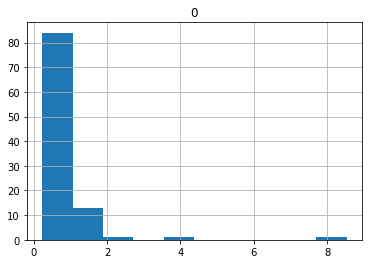

C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [11]:
import matplotlib.pyplot as plt


df = pd.DataFrame(times)

df.hist()

<AxesSubplot:>

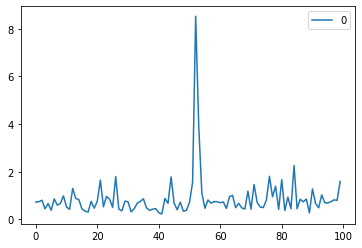

C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [12]:
df.plot()

In [15]:
df_labels.head()

,center-lat,center-long,polygon,Labels combined,tile date,area (km2)
0,5.77459,9.16861,"{""type"":""Polygon"",""coordinates"":[[[9.088783,5....","ISL, Rainforest",2020-01-25,207.84
1,5.75499,8.92339,"{""type"":""Polygon"",""coordinates"":[[[8.891888,5....","ISL, Rainforest",2020-01-25,89.56
2,5.59555,13.18814,"{""type"":""Polygon"",""coordinates"":[[[13.148403,5...","ISL, Rainforest",2020-01-14,28.52
3,5.35518,14.33673,"{""type"":""Polygon"",""coordinates"":[[[14.34763,5....","Rainforest, Mining, Savannah, Roads",2020-01-09,7.58
4,5.33908,13.10411,"{""type"":""Polygon"",""coordinates"":[[[13.02927,5....","ISL, Rainforest",2020-01-14,169.77


C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


<AxesSubplot:>

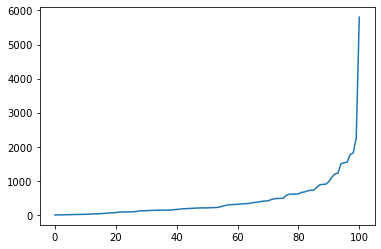

C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [20]:
df2 = df_labels.sort_values(by='area (km2)', ascending=True).reset_index()

df2['area (km2)'].plot()

In [21]:
df2.describe()

,index,center-lat,center-long,area (km2)
count,101.000000,101.000000,101.00000,101.000000
mean,50.000000,2.010868,15.88086,439.364158
std,29.300171,2.110722,3.47067,700.853168
min,0.000000,-3.277370,8.64006,1.270000
25%,25.000000,1.179790,13.44727,91.770000
50%,50.000000,2.345960,15.53432,207.960000
75%,75.000000,3.311430,18.34579,492.920000
max,100.000000,5.774590,25.59763,5801.830000


C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [27]:
df2 = df2.reset_index()
df2.head()

,level_0,index,center-lat,center-long,polygon,Labels combined,tile date,area (km2)
0,0,95,-2.63893,17.98114,"{""type"":""Polygon"",""coordinates"":[[[17.972131,-...",Fire,2020-08-12,1.27
1,1,96,-2.70602,18.07841,"{""type"":""Polygon"",""coordinates"":[[[18.066158,-...","Fire, Shifting cultivation",2020-08-12,2.08
2,2,94,-2.63821,18.80911,"{""type"":""Polygon"",""coordinates"":[[[18.795612,-...",Fire,2020-08-12,2.46
3,3,60,1.89876,13.44727,"{""type"":""Polygon"",""coordinates"":[[[13.438854,1...","Rainforest, Mining",2020-01-24,5.20
4,4,3,5.35518,14.33673,"{""type"":""Polygon"",""coordinates"":[[[14.34763,5....","Rainforest, Mining, Savannah, Roads",2020-01-09,7.58


C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


<AxesSubplot:xlabel='level_0', ylabel='area (km2)'>

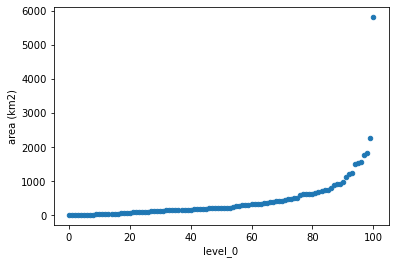

In [28]:
df2.plot.scatter(x='level_0', y='area (km2)')

In [29]:
df2.tail()

,level_0,index,center-lat,center-long,polygon,Labels combined,tile date,area (km2)
96,96,91,-2.39741,18.34579,"{""type"":""Polygon"",""coordinates"":[[[18.280563,-...","Rainforest, Shifting cultivation, Roads, Water...",2020-08-12,1547.71
97,97,74,1.19382,15.58479,"{""type"":""Polygon"",""coordinates"":[[[15.325584,1...","ISL, Rainforest",2020-02-15,1770.01
98,98,77,1.09359,16.11729,"{""type"":""Polygon"",""coordinates"":[[[15.837479,1...",Rainforest,2020-02-15,1818.90
99,99,59,2.04650,20.91110,"{""type"":""Polygon"",""coordinates"":[[[20.107727,1...","River, Rainforest",2020-03-10,2259.77
100,100,80,0.70345,20.66940,"{""type"":""Polygon"",""coordinates"":[[[20.163345,1...","Rainforest, River, Habitation, Shifting cultiv...",2020-04-14,5801.83


C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [5]:
process_datasource_custom_daterange(source,sensor, export_folder, fc, date_range_list)

101 features have been loaded
processing  1_dynamic_date_range_v3_secondary_sort_Dec__1_14:47:50_2020
Polygon 1 successfully merged with offset 45.0
processing  2_dynamic_date_range_v3_secondary_sort_Dec__1_14:47:53_2020
Polygon 2 successfully merged with offset 45.0
processing  3_dynamic_date_range_v3_secondary_sort_Dec__1_14:47:55_2020
Polygon 3 successfully merged with offset 45.0
processing  4_dynamic_date_range_v3_secondary_sort_Dec__1_14:47:59_2020
Polygon 4 successfully merged with offset 45.0
processing  5_dynamic_date_range_v3_secondary_sort_Dec__1_14:48:03_2020
Polygon 5 successfully merged with offset 45.0
processing  6_dynamic_date_range_v3_secondary_sort_Dec__1_14:48:07_2020
Polygon 6 is increasing offset to 90
Polygon 6 is increasing offset to 180
Polygon 6 is increasing offset to two years
Polygon 6 successfully merged with offset two years
processing  7_dynamic_date_range_v3_secondary_sort_Dec__1_14:48:17_2020
Polygon 7 successfully merged with offset 45.0
processing  8

processing  60_dynamic_date_range_v3_secondary_sort_Dec__1_14:52:38_2020
Polygon 60 successfully merged with offset 45.0
processing  61_dynamic_date_range_v3_secondary_sort_Dec__1_14:52:42_2020
Polygon 61 successfully merged with offset 45.0
processing  62_dynamic_date_range_v3_secondary_sort_Dec__1_14:52:44_2020
Polygon 62 successfully merged with offset 45.0
processing  63_dynamic_date_range_v3_secondary_sort_Dec__1_14:52:46_2020
Polygon 63 successfully merged with offset 45.0
processing  64_dynamic_date_range_v3_secondary_sort_Dec__1_14:52:51_2020
Polygon 64 successfully merged with offset 45.0
processing  65_dynamic_date_range_v3_secondary_sort_Dec__1_14:52:57_2020
Polygon 65 successfully merged with offset 45.0
processing  66_dynamic_date_range_v3_secondary_sort_Dec__1_14:53:00_2020
Polygon 66 successfully merged with offset 45.0
processing  67_dynamic_date_range_v3_secondary_sort_Dec__1_14:53:03_2020
Polygon 67 successfully merged with offset 45.0
processing  68_dynamic_date_rang

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [8]:
date_range_list[0]

{'start_date': '2019-12-11',
 'end_date': '2020-03-10',
 'original_date': Timestamp('2020-01-25 00:00:00'),
 'day_offset': 45.0,
 'area': 207.84}

In [9]:
date_range_list[5]

{'start_date': '2019-12-11',
 'end_date': '2020-03-10',
 'original_date': Timestamp('2020-01-25 00:00:00'),
 'day_offset': 45.0,
 'area': 131.07}

In [10]:
date_range_list[6]

{'start_date': '2019-11-15',
 'end_date': '2020-02-13',
 'original_date': Timestamp('2019-12-30 00:00:00'),
 'day_offset': 45.0,
 'area': 885.58}

In [5]:
exports = process_datasource_custom_daterange(source,sensor, export_folder, fc, date_range_list)

101 features have been loaded
processing  1_dynamic_date_range_v4_secondary_sort_using_area_Dec__1_14:57:20_2020
Polygon 1 successfully merged with offset 45.0
processing  2_dynamic_date_range_v4_secondary_sort_using_area_Dec__1_14:57:23_2020
Polygon 2 successfully merged with offset 45.0
processing  3_dynamic_date_range_v4_secondary_sort_using_area_Dec__1_14:57:26_2020
Polygon 3 successfully merged with offset 45.0
processing  4_dynamic_date_range_v4_secondary_sort_using_area_Dec__1_14:57:30_2020
Polygon 4 successfully merged with offset 45.0
processing  5_dynamic_date_range_v4_secondary_sort_using_area_Dec__1_14:57:33_2020
Polygon 5 successfully merged with offset 45.0
processing  6_dynamic_date_range_v4_secondary_sort_using_area_Dec__1_14:57:37_2020
Polygon 6 is increasing offset to 90
Polygon 6 is increasing offset to 180
Polygon 6 is increasing offset to two years
Polygon 6 successfully merged with offset two years
processing  7_dynamic_date_range_v4_secondary_sort_using_area_Dec_

Polygon 55 successfully merged with offset 45.0
processing  56_dynamic_date_range_v4_secondary_sort_using_area_Dec__1_15:02:10_2020
Polygon 56 successfully merged with offset 45.0
processing  57_dynamic_date_range_v4_secondary_sort_using_area_Dec__1_15:02:15_2020
Polygon 57 successfully merged with offset 45.0
processing  58_dynamic_date_range_v4_secondary_sort_using_area_Dec__1_15:02:21_2020
Polygon 58 is increasing offset to 90
Polygon 58 is increasing offset to 180
Polygon 58 successfully merged with offset 180
processing  59_dynamic_date_range_v4_secondary_sort_using_area_Dec__1_15:02:29_2020
Polygon 59 successfully merged with offset 45.0
processing  60_dynamic_date_range_v4_secondary_sort_using_area_Dec__1_15:02:33_2020
Polygon 60 successfully merged with offset 45.0
processing  61_dynamic_date_range_v4_secondary_sort_using_area_Dec__1_15:02:37_2020
Polygon 61 successfully merged with offset 45.0
processing  62_dynamic_date_range_v4_secondary_sort_using_area_Dec__1_15:02:40_2020


C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [6]:
exports = process_datasource(source, sensor, export_folder, fc)

101 features have been loaded
processing  1_v10_secondary_sort_no_dynamic_date_range_Dec__1_16:24:28_2020
Polygon 1 successfully merged with offset <preset date>
processing  2_v10_secondary_sort_no_dynamic_date_range_Dec__1_16:24:35_2020
Polygon 2 successfully merged with offset <preset date>
processing  3_v10_secondary_sort_no_dynamic_date_range_Dec__1_16:24:43_2020
Polygon 3 successfully merged with offset <preset date>
processing  4_v10_secondary_sort_no_dynamic_date_range_Dec__1_16:24:57_2020
Polygon 4 successfully merged with offset <preset date>
processing  5_v10_secondary_sort_no_dynamic_date_range_Dec__1_16:25:11_2020
Polygon 5 successfully merged with offset <preset date>
processing  6_v10_secondary_sort_no_dynamic_date_range_Dec__1_16:25:24_2020
Polygon 6 successfully merged with offset <preset date>
processing  7_v10_secondary_sort_no_dynamic_date_range_Dec__1_16:25:30_2020


EEException: Computation timed out.

C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


### START HERE (AGAIN)

In [1]:
import ee

help(ee.batch.Export.image)

Help on class image in module ee.batch:

class image(builtins.object)
 |  image(image, description='myExportImageTask', config=None)
 |  
 |  A static class with methods to start image export tasks.
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Forbids class instantiation.
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(cls, image, description='myExportImageTask', config=None)
 |      Creates a task to export an EE Image to Google Drive or Cloud Storage.
 |      
 |      Args:
 |        image: The image to be exported.
 |        description: Human-readable name of the task.
 |        config: A dictionary that will be copied and used as parameters
 |            for the task:
 |            - region: The lon,lat coordinates for a LinearRing or Polygon
 |              specifying the region to export. Can be specified as a nested
 |              lists of numbers or a serialized string. Default

C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [1]:
from pandas.tseries.offsets import DateOffset
import ee
import yaml
import time
import os
import json
import pandas as pd
from utils import exportImageToGDrive,exportImageToGCS
from download_sen12 import *

ee.Initialize()

C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [2]:
config_dict = load_config('config.yml')
source = config_dict['data_list'][0]
sensor = config_dict['sensors'][0]
# export_folder = config_dict['drive_folder']
export_folder = config_dict['bucket']

print(export_folder)

project-canopy-temp-2


C:\Users\David\canopy\canopy-gis\google-earth-explore\GEE_DataDownloader\download_sen12.py:400: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(stream)


In [3]:
def import_aois(csv_loc, Full_Congo_Pull=False, start_date=None,
                end_date=None, days_duration=90, poly_start=0, poly_limit=None):
    features = []
    polygons = []
    day_offset = days_duration / 2
    start_end_list = []
    
    if Full_Congo_Pull:
        df_congo_tile_list = pd.read_csv(csv_loc)
        for index,tile,polygon in df_congo_tile_list.itertuples():
            poly_obj = ee.Geometry.Polygon(json.loads(polygon))
            feature = ee.Feature(poly_obj,{"name":tile})
            features.append(feature)
    else:
        feature_id = poly_start
        
        if poly_limit:
            df_labels = pd.read_csv(csv_loc, skiprows=range(1, poly_start+1), nrows=poly_limit)
        else:
            df_labels = pd.read_csv(csv_loc, skiprows=range(1, poly_start+1))

        df_labels = df_labels[["center-lat","center-long","polygon","Labels combined","tile date","area (km2)"]]
        df_labels["tile date"] = pd.to_datetime(df_labels["tile date"])
        start = (df_labels["tile date"] + DateOffset(days=-day_offset))
        end = (df_labels["tile date"] + DateOffset(days=day_offset))
        for i in range(len(start)):
            start_date = str(start[i])[:10]
            end_date = str(end[i])[:10]
            original_date = df_labels.loc[i, 'tile date']
            area = df_labels.loc[i, 'area (km2)']
            date_dict = {
                'start_date': start_date,
                'end_date': end_date,
                'original_date': original_date,
                'day_offset': day_offset,
                'area': area
            }
            start_end_list.append(date_dict)

        for polygon in df_labels["polygon"]:
            polygons.append(json.loads(polygon)["coordinates"])
            
        for poly in polygons:
            # create an roi. first item in Misha's label list
            feature_id += 1 
            # create geometry object, create feature object, append to features list for feature collection creation 
            polys = ee.Geometry.Polygon(poly)
            feature = ee.Feature(polys,{"name":feature_id})
            features.append(feature)
            
    return ee.FeatureCollection(features),start_end_list,df_labels


# ### CHANGE BELOW PATH ###
zhenya_label_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Tiles_v3/Polygon_List/polygons_101320.csv"
david__label_path = 'D:/canopy_data/csvs/polygons_101320.csv'
#zhenya_tilelist_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Geometry/tile_lists/shub_tile_list/tiles_polygons_full.csv"

In [4]:
fc,date_range_list,df_labels = import_aois(david__label_path, poly_limit=1)

In [5]:
exports = process_datasource_custom_daterange(source,sensor, export_folder, fc, date_range_list)

1 features have been loaded
processing  1_test_export_chipping_Dec__7_15:14:19_2020
Tile is None
clipping in makeImageCollection
secondary sort -- getting infos
got info for CLOUDY_PERCENTAGE
got info for CLOUDY_PIXEL_PERCENTAGE
got info for id
Polygon 1 successfully merged with offset 45.0
clipping to ROI in export_single_feature


C:\Anaconda3\envs\cloud_removal\lib\site-packages\gevent\hub.py:158: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [10]:
exports

[None]